# Flanker

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [1]:
# necessary imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
from scipy.stats import norm


In [2]:
# class for drift diffusion model
class Spotlight_DDM:
    def __init__(self, name, starting_point: float):
        self.name = name  # to distinguish models properly
        self.starting_point = starting_point
        self.z = starting_point

    def run(self, p_total, r, sd_a, threshold, noise_std, non_decision_time, dt, max_time, increment_step: float = 0):
        """
        Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

        Arguments:
        - p_total: perceptual input for target and distractor flankers of shape [target, distractors] (values can be -1 (left) or 1(right))
        - sd_a: standard deviation of attention allocation distribution (spotlight width)
        - r: temporal decay of the standard deviation of attention (spotlight narrowing term)
        - threshold: evidence needed to reach a decision
        - noise_std: standard deviation of the noise term
        - non_decision_time: time not included in the evidence accumulation process
        - dt: time increment
        - max_time: maximum simulation time

        Returns:
        - decision_time: the time taken to reach a decision
        - evidence_over_time: the evidence accumulated over time
        - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
        """
        # Initialize evidence accumulation process
        time = non_decision_time
        evidence = self.z
        evidence_over_time = [evidence]

        # Run the simulation until a decision boundary is reached or max time is exceeded
        while time < max_time:
            # Increment the evidence by the drift and some noise (drift rate is a time-varying evidence drift rate)
            if sd_a >= 0.001 + r:
                # only decay the attention standard deviation until a certain limit
                sd_a = sd_a - r
            attention_outer = 2 * norm(loc=0, scale=sd_a).cdf(-0.5)
            drift_rate = ( 2 * attention_outer * p_total[1] + (1 - attention_outer) * p_total[0])  # compute time_varying evidence drift rate
            evidence += drift_rate * dt + np.sqrt(dt) * np.random.normal(0, noise_std)
            evidence_over_time.append(evidence)
            time += dt  # Increment the time

            # Check if the evidence has reached either threshold
            if evidence >= threshold:
                # Decision made for the upper threshold
                self.adjust_starting_point(1, increment_step)
                return time, evidence_over_time, 1

            elif evidence <= 0:
                # Decision made for the lower threshold
                self.adjust_starting_point(-1, increment_step)
                return time, evidence_over_time, -1

        # If no decision has been made by max_time, return the current state
        return time, evidence_over_time, 0

    def adjust_starting_point(self, direction: int, increment: float):
        if (self.z >= self.starting_point and direction == 1) or (self.z <= self.starting_point and direction == -1):
            self.z += increment * direction
            # print(f"Adjusted to {self.z}")
        else:
            self.z = self.starting_point
            # print("Reset to default.")
            
ddm = Spotlight_DDM("my_ddm", starting_point=1.0)


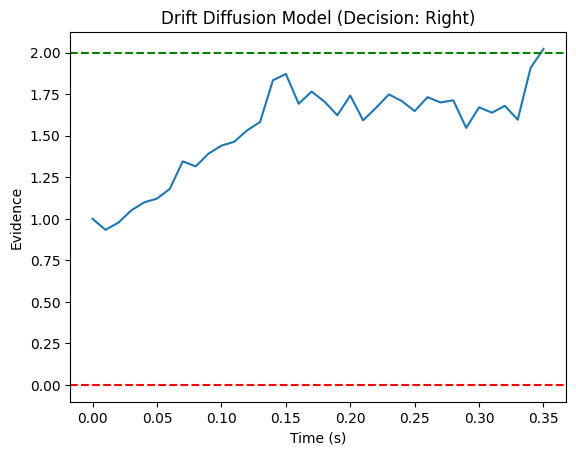

In [3]:
p_total = [1, -1] # incongruent trial with target pointing to the right and distractors pointing left
r = 0.2           # attention narrowing parameter
sd_a = 1          # initial attention standard deviation
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

decision_time, evidence_over_time, decision = ddm.run(p_total = p_total,
                                                  r = r,
                                                  sd_a = sd_a,
                                                  threshold = a,
                                                  noise_std = sigma,
                                                  non_decision_time = t0,
                                                  dt = dt,
                                                  max_time = max_time,
                                                  increment_step=0.05)



plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
plt.axhline(y=a, color='green', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Evidence')
plt.title(f'Drift Diffusion Model (Decision: {"Right" if decision == 1 else "Left" if decision == -1 else "None"})')
plt.show()

*The targeted hypothesis is that after the multiple trials where the flanker pointed in a certain direction, the participant is biased towards or against this flanker direction and the the offset (the starting point z) shifts towards one of the decision boundaries.*

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [4]:
# YOUR MODEL SIMULATION CODE GOES HERE

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [5]:
# YOUR PARAMETER FITTING CODE GOES HERE

## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [6]:
# YOUR PARAMETER RECOVERY CODE GOES HERE

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [7]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [8]:
# YOUR MODEL COMPARISON CODE GOES HERE